## Getting ready

In [99]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [74]:
import string
import random

def random_id(length=8):
    voc = string.ascii_lowercase + string.digits
    return ''.join(random.choice(voc) for i in range(length))

In [75]:
class TabularTransformer(BaseEstimator, TransformerMixin):
    
    def instantiate(self, param):
        if isinstance(param, str):
            return [param]
        elif isinstance(param, list):
            return param
        else:
            return None
    
    def __init__(self, numeric=None, dates=None, ordinal=None, cat=None, highcat=None,
                 variance_threshold=0.0, missing_imputer='mean', use_multivariate_imputer=False,
                 add_missing_indicator=True, quantile_transformer='normal', scaler=True,
                 ordinal_categories='auto', date_format='%d/%m/%Y', hours_secs=False):
        
        self.numeric = self.instantiate(numeric)
        self.dates = self.instantiate(dates)
        self.ordinal = self.instantiate(ordinal)
        self.cat  = self.instantiate(cat)
        self.highcat = self.instantiate(highcat)
        self.columns = None
        self.vocabulary = None
        
        self.numeric_process = assemble_numeric_pipeline(variance_threshold=variance_threshold, 
                                                         imputer=missing_imputer, 
                                                         multivariate_imputer=use_multivariate_imputer, 
                                                         add_indicator=add_missing_indicator,
                                                         quantile_transformer=quantile_transformer,
                                                         scaler=scaler)
        self.dates_process = DateProcessor(date_format=date_format, hours_secs=hours_secs)
        self.ordinal_process = FeatureUnion([('ordinal', OrdinalEncoder(categories=ordinal_categories)),
                                             ('categorial', Pipeline(steps=[('string_converter', ToString()),
                                                  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))]))])
        self.cat_process = Pipeline(steps=[('string_converter', ToString()),
                                           ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                           ('onehot', OneHotEncoder(handle_unknown='ignore'))])
        self.highcat_process = LEncoder()
        
    def fit(self, X, y=None, **fit_params):
        self.columns = list()
        if self.numeric:
            self.numeric_process.fit(X[self.numeric])
            self.columns += derive_numeric_columns(X[self.numeric], 
                                                   self.numeric_process).to_list()
        if self.dates:
            self.dates_process.fit(X[self.dates])
            self.columns += self.dates_process.columns.to_list()
        if self.ordinal:
            self.ordinal_process.fit(X[self.ordinal])
            self.columns += self.ordinal + derive_ohe_columns(X[self.ordinal], 
                                                             self.ordinal_process.transformer_list[1][1])
        if self.cat:
            self.cat_process.fit(X[self.cat])
            self.columns += derive_ohe_columns(X[self.cat], 
                                               self.cat_process)
        if self.highcat:
            self.highcat_process.fit(X[self.highcat])
            self.vocabulary = dict(zip(self.highcat, self.highcat_process.dictionary_size))
            self.columns = [self.columns, self.highcat]
        return self
    
    def transform(self, X, y=None, **fit_params):
        flat_matrix = list()
        if self.numeric:
            flat_matrix.append(self.numeric_process.transform(X[self.numeric])
                               .astype(np.float32))
        if self.dates:
            flat_matrix.append(self.dates_process.transform(X[self.dates])
                               .values
                               .astype(np.float32))
        if self.ordinal:
            flat_matrix.append(self.ordinal_process.transform(X[self.ordinal])
                               .todense()
                               .astype(np.float32))
        if self.cat:
            flat_matrix.append(self.cat_process.transform(X[self.cat])
                               .todense()
                               .astype(np.float32))
        if self.highcat:
            cat_vectors = self.highcat_process.transform(X[self.highcat])
            if len(flat_matrix) > 0:
                return [np.hstack(flat_matrix)] + cat_vectors
            else:
                return cat_vectors
        else:
            return np.hstack(flat_matrix)

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

In [76]:
class DateProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, date_format='%d/%m/%Y', hours_secs=False):
        self.format = date_format
        self.columns = None
        # see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
        self.time_transformations = [
            ('day_sin', lambda x: np.sin(2*np.pi*x.dt.day/31)),
            ('day_cos', lambda x: np.cos(2*np.pi*x.dt.day/31)),
            ('dayofweek_sin', lambda x: np.sin(2*np.pi*x.dt.dayofweek/6)),
            ('dayofweek_cos', lambda x: np.cos(2*np.pi*x.dt.dayofweek/6)),
            ('month_sin', lambda x: np.sin(2*np.pi*x.dt.month/12)),
            ('month_cos', lambda x: np.cos(2*np.pi*x.dt.month/12)),
            ('year', lambda x: (x.dt.year - x.dt.year.min()) / (x.dt.year.max() - x.dt.year.min()))
        ]
        if hours_secs:
            self.time_transformations = [
                ('hour_sin', lambda x: np.sin(2*np.pi*x.dt.hour/23)),
                ('hour_cos', lambda x: np.cos(2*np.pi*x.dt.hour/23)),
                ('minute_sin', lambda x: np.sin(2*np.pi*x.dt.minute/59)),
                ('minute_cos', lambda x: np.cos(2*np.pi*x.dt.minute/59))
            ] + self.time_transformations
    
    def fit(self, X, y=None, **fit_params):
        self.columns = self.transform(X.iloc[0:1,:]).columns
        return self
    
    def transform(self, X, y=None, **fit_params):
        transformed = list()
        for col in X.columns:
            time_column = pd.to_datetime(X[col], format=self.format)
            for label, func in self.time_transformations:
                transformed.append(func(time_column))
                transformed[-1].name = transformed[-1].name + '_' + label
        transformed = pd.concat(transformed, axis=1)
        return transformed
            
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X) 

In [77]:
class ToString(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.astype(str)
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

In [78]:
class LEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.encoders = dict()
        self.dictionary_size = list()
        self.unk = -1
    
    def fit(self, X, y=None, **fit_params):
        for col in range(X.shape[1]):
            le = LabelEncoder()
            le.fit(X.iloc[:, col].fillna('_nan'))
            le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
            
            if '_nan' not in le_dict:
                max_value = max(le_dict.values())
                le_dict['_nan'] = max_value
            
            max_value = max(le_dict.values())
            le_dict['_unk'] = max_value
            
            self.unk = max_value
            self.dictionary_size.append(len(le_dict))
            col_name = X.columns[col]
            self.encoders[col_name] = le_dict
            
        return self
    
    def transform(self, X, y=None, **fit_params):
        output = list()
        for col in range(X.shape[1]):
            col_name = X.columns[col]
            le_dict = self.encoders[col_name]
            emb = X.iloc[:, col].fillna('_nan').apply(lambda x: le_dict.get(x, le_dict['_unk'])).values
            output.append(pd.Series(emb, name=col_name).astype(np.int32))
        return output

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

In [79]:
def assemble_numeric_pipeline(variance_threshold=0.0,
                              imputer='mean',
                              multivariate_imputer=False,
                              add_indicator=True,
                              quantile_transformer='normal',
                              scaler=True):
    numeric_pipeline = []
    if variance_threshold is not None:
        if isinstance(variance_threshold, float):
            numeric_pipeline.append(('var_filter', VarianceThreshold(threshold=variance_threshold)))
        else:
            numeric_pipeline.append(('var_filter', VarianceThreshold()))
        
        
    if imputer is not None:
        if multivariate_imputer is True:
            numeric_pipeline.append(('imputer', IterativeImputer(estimator=ExtraTreeRegressor(n_estimators=100,
                                                                                             n_jobs=-2),
                                                                initial_strategy=imputer,
                                                                add_indicator=add_indicator)))
        else:
            numeric_pipeline.append(('imputer', SimpleImputer(strategy=imputer,
                                                             add_indicator=add_indicator)))
            
    if quantile_transformer is not None:
        numeric_pipeline.append(('transformer', QuantileTransformer(n_quantiles=100,
                                                                    output_distribution=quantile_transformer,
                                                                    random_state=42)))
        
    if scaler is not None:
        numeric_pipeline.append(('scaler', StandardScaler()))
        
    return Pipeline(steps=numeric_pipeline)

In [83]:
def derive_numeric_columns(df, pipeline):
    columns = df.columns
    if 'var_filter' in pipeline.named_steps:
        threshold = pipeline.named_steps.var_filter.threshold
        columns = columns[pipeline.named_steps.var_filter.variances_>threshold]
    if 'imputer' in pipeline.named_steps:
        missing_cols = pipeline.named_steps.imputer.indicator_.features_
        if len(missing_cols) > 0:
            columns = columns.append(columns[missing_cols] + '_missing')
    return columns

In [87]:
def derive_ohe_columns(df, pipeline):
    return [str(col) + '_' + str(lvl) for col, lvls in zip(df.columns, pipeline.named_steps.onehot.categories_) for lvl in lvls]

In [88]:
example = pd.concat([pd.DataFrame([[1, 2, 3, np.nan], [1, 3, np.nan, 4], [1, 2, 2, 2]], columns = ['a', 'b', 'c', 'd']),
                     pd.DataFrame({'date_1': ['04/12/2018', '05/12/2019', '07/12/2020'],
                                    'date_2': ['12/5/2018', '15/5/2015', '18/5/2016'],
                                    'date_3': ['25/8/2019', '28/8/2018', '29/8/2017']}),
                     pd.DataFrame([['first', 'very much'], ['second', 'very little'], ['third', 'average']],
                                   columns = ['rank', 'importance']),
                     pd.DataFrame([['car', 1234], ['house', 6543], ['tree', 3456]], columns=['object', 'code']),
                     pd.DataFrame({'high_cat_1': [random_id(length=2) for i in range(3)], 
                                    'high_cat_2': [random_id(length=3) for i in range(3)], 
                                    'high_cat_3': [random_id(length=4) for i in range(3)]})
                    ], axis=1)

numeric_vars = ['a', 'b', 'c', 'd']
date_vars = ['date_1', 'date_2', 'date_3']
ordinal_vars = ['rank', 'importance']
cat_vars = ['object', 'code']
highcat_vars = ['high_cat_1', 'high_cat_2', 'high_cat_3']

In [89]:
tt = TabularTransformer(numeric=numeric_vars, dates=date_vars, ordinal=ordinal_vars, cat=cat_vars, highcat=highcat_vars)

In [90]:
input_list = tt.fit_transform(example)

/home/wil/anaconda3/envs/py365/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2615: UserWarning: n_quantiles (100) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [91]:
print([(item.shape, item.dtype) for item in input_list])

[((3, 40), dtype('float32')), ((3,), dtype('int32')), ((3,), dtype('int32')), ((3,), dtype('int32'))]


In [92]:
tt.columns

[['b',
  'c',
  'd',
  'c_missing',
  'd_missing',
  'date_1_day_sin',
  'date_1_day_cos',
  'date_1_dayofweek_sin',
  'date_1_dayofweek_cos',
  'date_1_month_sin',
  'date_1_month_cos',
  'date_1_year',
  'date_2_day_sin',
  'date_2_day_cos',
  'date_2_dayofweek_sin',
  'date_2_dayofweek_cos',
  'date_2_month_sin',
  'date_2_month_cos',
  'date_2_year',
  'date_3_day_sin',
  'date_3_day_cos',
  'date_3_dayofweek_sin',
  'date_3_dayofweek_cos',
  'date_3_month_sin',
  'date_3_month_cos',
  'date_3_year',
  'rank',
  'importance',
  'rank_first',
  'rank_second',
  'rank_third',
  'importance_average',
  'importance_very little',
  'importance_very much',
  'object_car',
  'object_house',
  'object_tree',
  'code_1234',
  'code_3456',
  'code_6543'],
 ['high_cat_1', 'high_cat_2', 'high_cat_3']]

In [93]:
tt.vocabulary

{'high_cat_1': 5, 'high_cat_2': 5, 'high_cat_3': 5}

# Setting up a data generator

## Getting ready

In [94]:
from tensorflow.keras.utils import Sequence

## How to do it

In [95]:
class DataGenerator(Sequence):
    """
    Generates data for Keras
    """
    def __init__(self, X, y,
                 tabular_transformer=None,
                 batch_size=32, 
                 shuffle=False,
                 dict_output=False
                 ):
        
        'Initialization'
        self.X = X
        self.y = y
        self.tbt = tabular_transformer
        self.tabular_transformer = tabular_transformer
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dict_output = dict_output
        self.indexes = self._build_index()
        self.on_epoch_end()
        self.item = 0
    
    def _build_index(self):
        """
        Builds an index from data
        """
        return np.arange(len(self.y))
    
    def on_epoch_end(self):
        """
        At the end of every epoch, shuffle if required
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        """
        Returns the number of batches per epoch
        """
        return int(len(self.indexes) / self.batch_size) + 1
    
    
    def __iter__(self):
        """
        returns an iterable
        """
        for i in range(self.__len__()):
            self.item = i
            yield self.__getitem__(index=i)
            
        self.item = 0
        
    def __next__(self):
        return self.__getitem__(index=self.item)
    
    def __call__(self):
        return self.__iter__()
            
    def __data_generation(self, selection):
        if self.tbt is not None:
            if self.dict_output:
                dct = {'input_'+str(j) : arr for j, arr in enumerate(self.tbt.transform(self.X.iloc[selection, :]))}
                return dct, self.y[selection]
            else:
                return self.tbt.transform(self.X.iloc[selection, :]), self.y[selection]
        else:
            return self.X.iloc[selection, :], self.y[selection]
        
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        samples, labels = self.__data_generation(indexes)
        return samples, labels, [None]

# Creating custom activations for tabular data

## Getting ready

In [96]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [101]:
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

keras.utils.get_custom_objects().update({'gelu': keras.layers.Activation(gelu)})

def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

keras.utils.get_custom_objects().update({'mish': keras.layers.Activation(mish)})

## How it works...

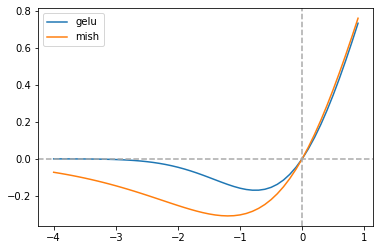

In [103]:
gelu_vals = list()
mish_vals = list()
abscissa = np.arange(-4, 1, 0.1)
for val in abscissa:
    gelu_vals.append(gelu(tf.cast(val, tf.float32)).numpy())
    mish_vals.append(mish(tf.cast(val, tf.float32)).numpy())
    
plt.plot(abscissa, gelu_vals, label='gelu')
plt.plot(abscissa, mish_vals, label='mish')
plt.axvline(x=0.0, linestyle='--', color='darkgray')
plt.axhline(y=0.0, linestyle='--', color='darkgray')
plt.legend()
plt.show()

# Running a test on a difficult problem

## Getting ready

In [104]:
import tensorflow as tf
import tensorflow.keras as keras

In [105]:
tf.compat.v1.disable_eager_execution()

In [111]:
from catboost.datasets import amazon

X, Xt = amazon()
y = X["ACTION"].apply(lambda x: 1 if x == 1 else 0).values
X.drop(["ACTION"], axis=1, inplace=True)

In [113]:
X.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [114]:
Xt.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [116]:
y

array([1, 1, 1, ..., 1, 1, 1])

## How to do it...

In [123]:
def dnn(categorical_variables, categorical_counts, feature_selection_dropout=0.2, categorical_dropout=0.1,
        first_dense=256, second_dense=256, dense_dropout=0.2, activation_type=gelu):
    
    categorical_inputs = []
    categorical_embeddings = []
    
    for category in categorical_variables:
        categorical_inputs.append(keras.layers.Input(shape=[1], name=category))
        category_counts = categorical_counts[category]
        categorical_embeddings.append(keras.layers.Embedding(category_counts+1, int(np.log1p(category_counts)+1),
                                                             name = category + "_embed")(categorical_inputs[-1]))
        
    def flatten_dropout(x, categorical_dropout):
        return keras.layers.Flatten()(keras.layers.SpatialDropout1D(categorical_dropout)(x))
    
    categorical_logits = [flatten_dropout(cat_emb, categorical_dropout) for cat_emb in categorical_embeddings]
    categorical_concat = keras.layers.Concatenate(name='categorical_concat')(categorical_logits)
    
    x = keras.layers.Dense(first_dense, activation=activation_type)(categorical_concat)
    x = keras.layers.Dropout(dense_dropout)(x)
    x = keras.layers.Dense(second_dense, activation=activation_type)(x)
    x = keras.layers.Dropout(dense_dropout)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(categorical_inputs, output)
    
    return model

In [126]:
from sklearn.metrics import average_precision_score, roc_auc_score

def mAP(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.double)

def auc(y_true, y_pred):
    try:
        return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
    
    except:
        return 0.5
    
def compile_model(model, loss, metrics, optimizer):
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label='Train ' + measure)
        panel.plot(history.epoch, history.history['val_' + measure], label="Validation " + measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

Epoch 1/30


/home/wil/anaconda3/envs/py365/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


43/43 - 2s - loss: 0.6810 - auc: 0.5330 - mAP: 0.9479 - val_loss: 0.6686 - val_auc: 0.5358 - val_mAP: 0.9499
Epoch 2/30
43/43 - 1s - loss: 0.6537 - auc: 0.5452 - mAP: 0.9509 - val_loss: 0.6348 - val_auc: 0.5525 - val_mAP: 0.9526
Epoch 3/30
43/43 - 1s - loss: 0.6107 - auc: 0.5688 - mAP: 0.9522 - val_loss: 0.5805 - val_auc: 0.5665 - val_mAP: 0.9552
Epoch 4/30
43/43 - 1s - loss: 0.5434 - auc: 0.5960 - mAP: 0.9567 - val_loss: 0.4999 - val_auc: 0.5797 - val_mAP: 0.9573
Epoch 5/30
43/43 - 1s - loss: 0.4532 - auc: 0.6048 - mAP: 0.9584 - val_loss: 0.4030 - val_auc: 0.5963 - val_mAP: 0.9596
Epoch 6/30
43/43 - 1s - loss: 0.3565 - auc: 0.6441 - mAP: 0.9638 - val_loss: 0.3150 - val_auc: 0.6147 - val_mAP: 0.9622
Epoch 7/30
43/43 - 1s - loss: 0.2824 - auc: 0.6578 - mAP: 0.9649 - val_loss: 0.2573 - val_auc: 0.6370 - val_mAP: 0.9652
Epoch 8/30
43/43 - 1s - loss: 0.2378 - auc: 0.6963 - mAP: 0.9703 - val_loss: 0.2277 - val_auc: 0.6616 - val_mAP: 0.9682
Epoch 9/30
43/43 - 1s - loss: 0.2152 - auc: 0.7267 

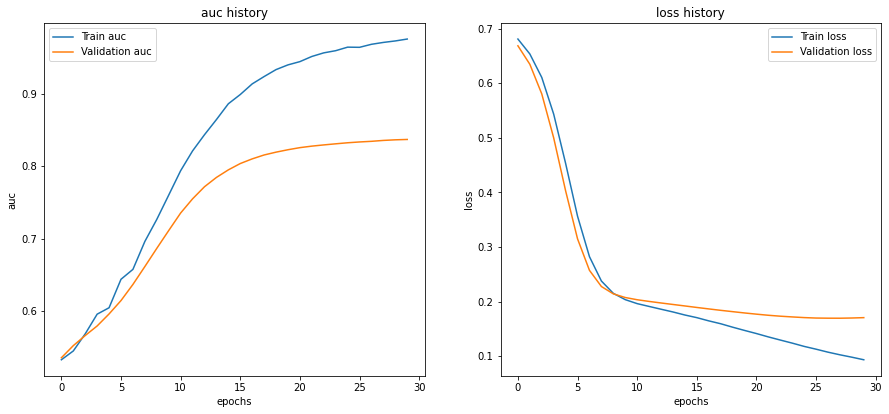

/home/wil/anaconda3/envs/py365/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 1/30


/home/wil/anaconda3/envs/py365/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


43/43 - 3s - loss: 0.6800 - auc: 0.5092 - mAP: 0.9453 - val_loss: 0.6656 - val_auc: 0.5278 - val_mAP: 0.9478
Epoch 2/30
43/43 - 1s - loss: 0.6461 - auc: 0.5322 - mAP: 0.9473 - val_loss: 0.6249 - val_auc: 0.5396 - val_mAP: 0.9493
Epoch 3/30
43/43 - 1s - loss: 0.5938 - auc: 0.5571 - mAP: 0.9512 - val_loss: 0.5603 - val_auc: 0.5542 - val_mAP: 0.9514
Epoch 4/30
43/43 - 1s - loss: 0.5150 - auc: 0.5810 - mAP: 0.9548 - val_loss: 0.4704 - val_auc: 0.5715 - val_mAP: 0.9541
Epoch 5/30
43/43 - 1s - loss: 0.4186 - auc: 0.6047 - mAP: 0.9587 - val_loss: 0.3719 - val_auc: 0.5913 - val_mAP: 0.9572
Epoch 6/30
43/43 - 1s - loss: 0.3274 - auc: 0.6424 - mAP: 0.9632 - val_loss: 0.2931 - val_auc: 0.6120 - val_mAP: 0.9602
Epoch 7/30
43/43 - 1s - loss: 0.2638 - auc: 0.6707 - mAP: 0.9673 - val_loss: 0.2461 - val_auc: 0.6371 - val_mAP: 0.9636
Epoch 8/30
43/43 - 1s - loss: 0.2283 - auc: 0.7129 - mAP: 0.9723 - val_loss: 0.2228 - val_auc: 0.6631 - val_mAP: 0.9670
Epoch 9/30
43/43 - 1s - loss: 0.2112 - auc: 0.7405 

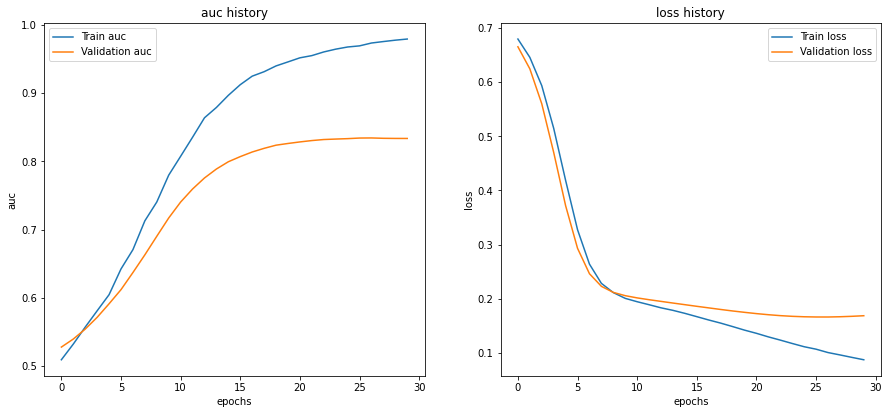

/home/wil/anaconda3/envs/py365/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 1/30


/home/wil/anaconda3/envs/py365/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


43/43 - 3s - loss: 0.6828 - auc: 0.5062 - mAP: 0.9423 - val_loss: 0.6692 - val_auc: 0.5397 - val_mAP: 0.9474
Epoch 2/30
43/43 - 1s - loss: 0.6531 - auc: 0.5347 - mAP: 0.9498 - val_loss: 0.6334 - val_auc: 0.5536 - val_mAP: 0.9521
Epoch 3/30
43/43 - 1s - loss: 0.6073 - auc: 0.5625 - mAP: 0.9540 - val_loss: 0.5755 - val_auc: 0.5679 - val_mAP: 0.9550
Epoch 4/30
43/43 - 1s - loss: 0.5357 - auc: 0.5820 - mAP: 0.9581 - val_loss: 0.4896 - val_auc: 0.5854 - val_mAP: 0.9577
Epoch 5/30
43/43 - 1s - loss: 0.4390 - auc: 0.6219 - mAP: 0.9615 - val_loss: 0.3866 - val_auc: 0.6069 - val_mAP: 0.9605
Epoch 6/30
43/43 - 1s - loss: 0.3387 - auc: 0.6555 - mAP: 0.9657 - val_loss: 0.2965 - val_auc: 0.6296 - val_mAP: 0.9632
Epoch 7/30
43/43 - 1s - loss: 0.2652 - auc: 0.6805 - mAP: 0.9693 - val_loss: 0.2434 - val_auc: 0.6563 - val_mAP: 0.9662
Epoch 8/30
43/43 - 1s - loss: 0.2250 - auc: 0.7222 - mAP: 0.9737 - val_loss: 0.2194 - val_auc: 0.6845 - val_mAP: 0.9692
Epoch 9/30
43/43 - 1s - loss: 0.2064 - auc: 0.7589 

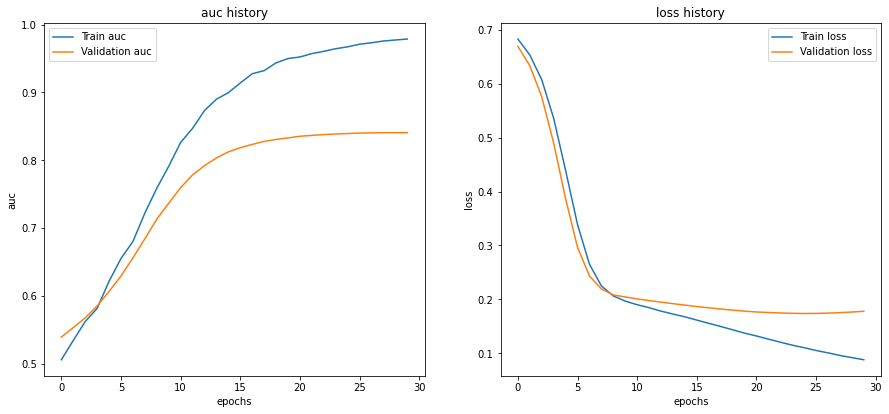

/home/wil/anaconda3/envs/py365/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


mean cv roc auc 0.840
mean cv average precision 0.985


In [127]:
from sklearn.model_selection import StratifiedKFold

SEED = 0
FOLDS = 3
BATCH_SIZE = 512

skf = StratifiedKFold(n_splits=FOLDS, 
                      shuffle=True, 
                      random_state=SEED)

roc_auc = list()
average_precision = list()
categorical_variables = X.columns.to_list()

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    
    tt = TabularTransformer(highcat = categorical_variables)

    tt.fit(X.iloc[train_idx])   
    categorical_levels = tt.vocabulary
    
    model = dnn(categorical_variables,
                categorical_levels, 
                feature_selection_dropout=0.1,
                categorical_dropout=0.1,
                first_dense=64,
                second_dense=64,
                dense_dropout=0.1,
                activation_type=mish)
    
    model = compile_model(model, 
                          keras.losses.binary_crossentropy, 
                          [auc, mAP], 
                          tf.keras.optimizers.Adam(learning_rate=0.0001))
    
    train_batch = DataGenerator(X.iloc[train_idx], 
                                y[train_idx],
                                tabular_transformer=tt,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
    
    val_X, val_y = tt.transform(X.iloc[test_idx]), y[test_idx]
    
    history = model.fit(train_batch,
                        validation_data=(val_X, val_y),
                        epochs=30,
                        class_weight=[1.0, (np.sum(y==0) / np.sum(y==1))],
                        verbose=2)
    
    print("\nFOLD %i" % fold)
    plot_keras_history(history, measures=['auc', 'loss'])
    
    preds = model.predict(val_X, verbose=0, batch_size=1024).flatten()

    roc_auc.append(roc_auc_score(y_true=val_y, y_score=preds))
    average_precision.append(average_precision_score(y_true=val_y, y_score=preds))
    
print(f"mean cv roc auc {np.mean(roc_auc):0.3f}")
print(f"mean cv average precision {np.mean(average_precision):0.3f}")